This notebook is going to be the most interesting one. Here I will make use of different techniques to make classifications. 

# Libraries

In [316]:
# standard
import numpy as np
import pandas as pd
# text mining
import spacy
from sklearn.metrics import classification_report
# machine learning
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [240]:
# LSTM
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Activation, Dropout, Input
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Load the data

In [378]:
# read all data frames
data2000 = pd.read_csv("new_data_2000.csv")
data4000 = pd.read_csv("new_data_4000.csv")
data6000 = pd.read_csv("new_data_6000.csv")
data8000 = pd.read_csv("new_data_8000.csv")
data10000 = pd.read_csv("new_data_10000.csv")

In [379]:
# merge data frames
data = pd.concat([data2000,data4000,data6000,data8000,data10000])
data

,index,username,date,retweets,favorites,text,emotion,emotion_probability
0,0,realDonaldTrump,09.02.20 00:47,13459,72445,A great coach and a fantastic guy. His endorse...,joy,0.887483
1,1,realDonaldTrump,08.02.20 22:08,47880,215503,Pete Rose played Major League Baseball for 24 ...,sadness,0.320811
2,2,realDonaldTrump,08.02.20 20:48,9452,37402,Total and complete Endorsement for Debbie Lesk...,joy,0.755680
3,3,realDonaldTrump,08.02.20 20:40,17545,62484,Governor Cuomo wanted to see me this weekend. ...,sadness,0.491409
4,4,realDonaldTrump,08.02.20 20:01,27437,120598,We will not be touching your Social Security o...,anger,0.648076
...,...,...,...,...,...,...,...,...
2212,10245,realDonaldTrump,07.01.17 16:02,24681,87739,Having a good relationship with Russia is a go...,sadness,0.522362
2213,10246,realDonaldTrump,07.01.17 13:03,16601,73661,Only reason the hacking of the poorly defended...,sadness,0.567706
2214,10247,realDonaldTrump,07.01.17 12:56,15401,60280,Intelligence stated very strongly there was ab...,sadness,0.490432
2215,10248,realDonaldTrump,07.01.17 04:53,13961,59218,Gross negligence by the Democratic National Co...,disgust,0.746146


In [380]:
# remove all NaN emotion
## via watson no classification possible
data = data[data["emotion_probability"] < 1.0] # remove those which could not be classified by Watson
data = data[data["emotion_probability"] != 0.0] #  pictures, links und hashtags


In [381]:
# reset index
data = data.reset_index(drop = True)

In [382]:
data.shape

(9585, 8)

# Data preprocessing - cleaning

In [384]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "entityrecognizer"])

In [385]:
def preprocess(text):
    doc = nlp(text)
    result = []
    
    for token in doc: 
        if token.is_alpha == True: 
                result.append(token.lemma_)
    return result

In [386]:
# print first 3 text - not cleand
for i in range(3):
    print("--")
    print(data.text[i])

--
A great coach and a fantastic guy. His endorsement of me in Indiana was a very big deal! https:// twitter.com/kyle__boone/st atus/1226234981808250880 …
--
Pete Rose played Major League Baseball for 24 seasons, from 1963-1986, and had more hits, 4,256, than any other player (by a wide margin). He gambled, but only on his own team winning, and paid a decades long price. GET PETE ROSE INTO THE BASEBALL HALL OF FAME. It’s Time!
--
Total and complete Endorsement for Debbie Lesko! @RepDLesko Love Arizona. https:// twitter.com/repdlesko/stat us/1225484090754899969 …


In [387]:
# print first 3 text - cleaned
for i in range(3):
    print("--")
    print(' '.join(word for word in preprocess(data.text[i])))

--
A great coach and a fantastic guy His endorsement of me in Indiana be a very big deal
--
Pete Rose play Major League Baseball for season from and have much hit than any other player by a wide margin He gamble but only on his own team win and pay a decade long price GET PETE ROSE INTO THE BASEBALL HALL OF FAME -PRON- Time
--
Total and complete Endorsement for Debbie Lesko Love Arizona


In [388]:
# create list of all cleand texts
text_preprocessed = []
for i in range(data.shape[0]):
    text_preprocessed.append(' '.join(word for word in preprocess(data.text[i])))

In [389]:
# add preprocessed text as column to the dataframe
data["text_preprocessed"] = text_preprocessed
data = data[['index', 'username', 'date', 'retweets', 'favorites', 'text','text_preprocessed', 'emotion',
       'emotion_probability']]

In [390]:
data

,index,username,date,retweets,favorites,text,text_preprocessed,emotion,emotion_probability
0,0,realDonaldTrump,09.02.20 00:47,13459,72445,A great coach and a fantastic guy. His endorse...,A great coach and a fantastic guy His endorsem...,joy,0.887483
1,1,realDonaldTrump,08.02.20 22:08,47880,215503,Pete Rose played Major League Baseball for 24 ...,Pete Rose play Major League Baseball for seaso...,sadness,0.320811
2,2,realDonaldTrump,08.02.20 20:48,9452,37402,Total and complete Endorsement for Debbie Lesk...,Total and complete Endorsement for Debbie Lesk...,joy,0.755680
3,3,realDonaldTrump,08.02.20 20:40,17545,62484,Governor Cuomo wanted to see me this weekend. ...,Governor Cuomo want to see me this weekend He ...,sadness,0.491409
4,4,realDonaldTrump,08.02.20 20:01,27437,120598,We will not be touching your Social Security o...,We will not be touch your Social Security or M...,anger,0.648076
...,...,...,...,...,...,...,...,...,...
9580,10245,realDonaldTrump,07.01.17 16:02,24681,87739,Having a good relationship with Russia is a go...,Having a good relationship with Russia be a go...,sadness,0.522362
9581,10246,realDonaldTrump,07.01.17 13:03,16601,73661,Only reason the hacking of the poorly defended...,Only reason the hack of the poorly defend DNC ...,sadness,0.567706
9582,10247,realDonaldTrump,07.01.17 12:56,15401,60280,Intelligence stated very strongly there was ab...,Intelligence state very strongly there be abso...,sadness,0.490432
9583,10248,realDonaldTrump,07.01.17 04:53,13961,59218,Gross negligence by the Democratic National Co...,Gross negligence by the Democratic National Co...,disgust,0.746146


# Split data - Train and test set

In [464]:
X = data["text_preprocessed"]
y = data["emotion"]
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)


In [465]:
print("Training:", len(X_train))
print("Test:", len(X_test))
print("Total:", len(X_train) +  len(X_test))

Training: 7668
Test: 1917
Total: 9585


In [470]:
y_train.value_counts()

joy        3712
sadness    1708
disgust    1224
anger       761
fear        263
Name: emotion, dtype: int64

In [467]:
y_test.value_counts()

joy        874
sadness    467
disgust    328
anger      188
fear        60
Name: emotion, dtype: int64

## Encode the label

In [405]:
np.unique(y_train)

array(['anger', 'disgust', 'fear', 'joy', 'sadness'], dtype=object)

In [408]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [409]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

## Unbalanced dataset

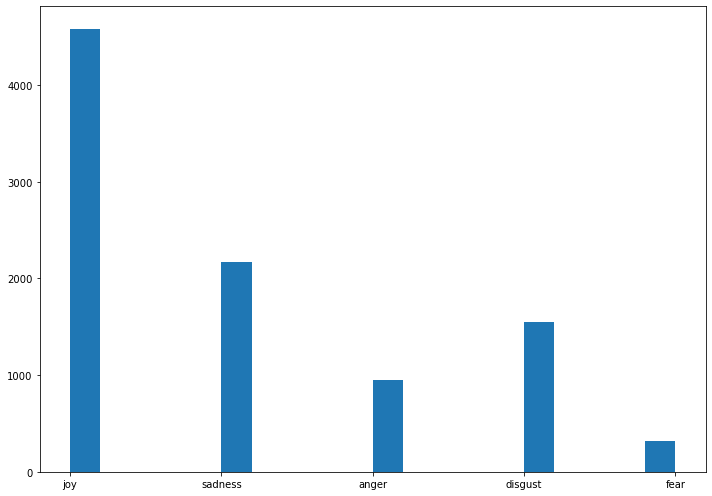

In [474]:
# Creating histogram 
fig, axs = plt.subplots(1, 1, 
                        figsize =(10, 7),  
                        tight_layout = True) 
  
axs.hist(y, bins = 20) 
  
# Show plot
plt.savefig("Histogram_emotions.png")
plt.show()

In [410]:
pd.Series(y_train).value_counts()

3    3674
4    1742
1    1245
0     746
2     261
dtype: int64

In [412]:
pd.Series(y_test).value_counts()

3    912
4    433
1    307
0    203
2     62
dtype: int64

In [476]:
(261 + 62)*5

1615

# Baseline model

The [dummy classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

## Train - score

In [414]:
# init strategies going to be unsed
strategies = ['most_frequent', 'stratified', 'uniform']
test_scores = []
# run test with different strategies
for strategy in strategies:
    dummy_clf = DummyClassifier(strategy = strategy)
    dummy_clf.fit(X_train,y_train)
    dummy_score = round(dummy_clf.score(X_train,y_train),3)
    test_scores.append(dummy_score)
# print results
for score,strategy in zip(test_scores,strategies):
    print(strategy, ":", score)

most_frequent : 0.479
stratified : 0.323
uniform : 0.204


In [415]:
# init strategies going to be unsed
strategies = ['most_frequent', 'stratified', 'uniform']
test_scores = []
# run test with different strategies
for strategy in strategies:
    dummy_clf = DummyClassifier(strategy = strategy)
    dummy_clf.fit(X_train,y_train)
    dummy_score = round(dummy_clf.score(X_test,y_test),3)
    test_scores.append(dummy_score)
# print results
for score,strategy in zip(test_scores,strategies):
    print(strategy, ":", score)

most_frequent : 0.476
stratified : 0.302
uniform : 0.207


# Naive Bayes classifier

## NBC - Baseline

In [287]:
# Step 1 & 2 in pipeline
# Step 1: vectorize speeches of train data
# Step 2: instantiate and fit Bayes model
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [302]:
# fit the model
text_clf.fit(X_train, y_train)
# make prediction
predicted = text_clf.predict(X_test)

### Train

In [418]:
predicted = text_clf.predict(X_train)
accuracy_MNB = round(np.mean(predicted == y_train),3)
print("The accuracy of the Naive Bayes classifier with default parameter is: {}".format(accuracy_MNB))

The accuracy of the Naive Bayes classifier with default parameter is: 0.153


In [419]:
predicted = text_clf.predict(X_test)
accuracy_MNB = round(np.mean(predicted == y_test),3)
print("The accuracy of the Naive Bayes classifier with default parameter is: {}".format(accuracy_MNB))

The accuracy of the Naive Bayes classifier with default parameter is: 0.167


In [424]:
#print(classification_report(y_test,predicted,target_names=emotions))

## NBC - grid search

In [443]:
# set the parameters
# - vectorizer binary=False/True
# - vectorizer ngram_range =(1, 1)
# - 
parameters = {
    'vect__binary': (True, False),
    'vect__ngram_range': [(1, 1), (1, 2)],
    #'tfidf__use_idf': (True, False),
    'clf__alpha': (1,0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1),
}

In [444]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)

In [445]:
gs_clf = gs_clf.fit(X_train, y_train)

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [446]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.2
vect__binary: True
vect__ngram_range: (1, 1)


## Train

In [447]:
# make prediction
predicted_balanced_naivebayes = gs_clf.predict(X_train)
# use classification report - precision, recall, F1 score, overfall accuracy
mean_pred_balanced_naivebayes = round(np.mean(predicted_balanced_naivebayes == y_train),3)
print("The accuracy is: {}".format(mean_pred_balanced_naivebayes))

The accuracy is: 0.822


## Test

In [448]:
# make prediction
predicted_balanced_naivebayes = gs_clf.predict(X_test)

In [449]:
# use classification report - precision, recall, F1 score, overfall accuracy
mean_pred_balanced_naivebayes = round(np.mean(predicted_balanced_naivebayes == y_test),3)
print("The accuracy is: {}".format(mean_pred_balanced_naivebayes))


The accuracy is: 0.644


In [450]:
#print(classification_report(y_test,predicted_balanced_naivebayes,target_names=emotions))

# Logistic regression - classifier

In [451]:
## I copy pasted the whole code section of problem 2 in this cell

# Step 1: vectorize speeches of train data
# Step 2: instantiate and fit Bayes model
text_clf2 = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression()),
])

parameters2 = {
    'vect__binary': (True, False),
    'vect__ngram_range': [(1, 1), (1, 2)],
    #'tfidf__use_idf': (True, False),
    'clf__solver': ('newton-cg', 'lbfgs', 'liblinear'),
}

In [452]:
gs_clf2 = GridSearchCV(text_clf2, parameters2, cv=5, iid=False, n_jobs=-1)

In [453]:
gs_clf2 = gs_clf2.fit(X_train, y_train)

/Users/phillipholscher/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [454]:
for param_name in sorted(parameters2.keys()):
    print("%s: %r" % (param_name, gs_clf2.best_params_[param_name]))

clf__solver: 'newton-cg'
vect__binary: True
vect__ngram_range: (1, 1)


## Train

In [455]:
# make prediction with the trained logistic regression classifier
predicted_balanced_logisticregression = gs_clf2.predict(X_train)
# use classification report - precision, recall, F1 score, overfall accuracy
mean_pred_balanced_logisticregression = round(np.mean(predicted_balanced_logisticregression == y_train),3)
print("The accuracy is: {}".format(mean_pred_balanced_logisticregression))


The accuracy is: 0.848


## Test

In [456]:
# make prediction with the trained logistic regression classifier
predicted_balanced_logisticregression = gs_clf2.predict(X_test)

In [457]:
# use classification report - precision, recall, F1 score, overfall accuracy
mean_pred_balanced_logisticregression = round(np.mean(predicted_balanced_logisticregression == y_test),3)
print("The accuracy is: {}".format(mean_pred_balanced_logisticregression))


The accuracy is: 0.719


In [458]:
print(classification_report(y_test,predicted_balanced_logisticregression,target_names=emotions))

              precision    recall  f1-score   support

         joy       0.73      0.30      0.42       203
     sadness       0.71      0.60      0.65       307
       anger       0.75      0.05      0.09        62
     disgust       0.76      0.94      0.84       912
        fear       0.63      0.64      0.63       433

    accuracy                           0.72      1917
   macro avg       0.71      0.50      0.53      1917
weighted avg       0.72      0.72      0.69      1917



# LSTM - classifier

## Data preprocessing

- convert into lower case
- convert the text into a preferred number representation

Therefore I´m going to define following variables
- vocab_size
- oov_token
- max_length
- padding_type
- trunction_type

In [33]:
#embedding_dim = 100
max_length = 0
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size=160000
#test_portion=.1

#corpus = []
vocab_size = 5853

In [34]:
# check max length of tweet
for tweet in data.text_preprocessed:
    if len(tweet.split()) > max_length:
        max_length = len(tweet.split())

In [35]:
max_length

59

In [36]:
# tokenize 
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

In [37]:
tokenizer.fit_on_texts(train_X)

In [38]:
word_index = tokenizer.word_index

In [39]:
word_index

{'<OOV>': 1,
 'the': 2,
 'be': 3,
 'to': 4,
 'and': 5,
 'a': 6,
 'of': 7,
 'in': 8,
 'have': 9,
 'do': 10,
 'that': 11,
 'for': 12,
 'i': 13,
 'on': 14,
 'great': 15,
 'it': 16,
 'they': 17,
 'this': 18,
 'with': 19,
 'will': 20,
 'our': 21,
 'you': 22,
 'we': 23,
 'much': 24,
 'he': 25,
 'president': 26,
 'all': 27,
 'not': 28,
 'very': 29,
 'get': 30,
 'by': 31,
 'at': 32,
 'so': 33,
 'democrats': 34,
 'no': 35,
 'people': 36,
 'country': 37,
 'go': 38,
 'but': 39,
 'just': 40,
 'thank': 41,
 'pron': 42,
 'my': 43,
 'now': 44,
 'big': 45,
 'who': 46,
 'nothing': 47,
 'their': 48,
 'trump': 49,
 'good': 50,
 'other': 51,
 'say': 52,
 'never': 53,
 'make': 54,
 'republican': 55,
 'from': 56,
 'would': 57,
 'what': 58,
 'up': 59,
 'want': 60,
 'year': 61,
 'his': 62,
 'impeachment': 63,
 'new': 64,
 'can': 65,
 'news': 66,
 'or': 67,
 'should': 68,
 'out': 69,
 'me': 70,
 'there': 71,
 'fake': 72,
 'call': 73,
 'about': 74,
 'many': 75,
 'time': 76,
 'american': 77,
 'like': 78,
 'see':

In [40]:
X_train_sequences = tokenizer.texts_to_sequences(train_X)

In [41]:
X_train_sequences[0]

[6, 15, 1896, 5, 6, 460, 348, 62, 315, 7, 70, 8, 3191, 3, 6, 29, 45, 103]

In [42]:
train_X[0]

'A great coach and a fantastic guy His endorsement of me in Indiana be a very big deal'

## kaggle - simple lstm for text classification

In [50]:
X = data.text_preprocessed
Y = data.emotion
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [53]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [56]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [57]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [64]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [67]:
# fit training data
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])



Train on 2460 samples, validate on 615 samples
Epoch 1/10
2460/2460 [==============================] - 5s 2ms/step - loss: -29.1922 - accuracy: 0.1589 - val_loss: -73.4331 - val_accuracy: 0.1480
Epoch 2/10
2460/2460 [==============================] - 4s 2ms/step - loss: -105.3394 - accuracy: 0.1634 - val_loss: -153.5060 - val_accuracy: 0.1480
Epoch 3/10
2460/2460 [==============================] - 4s 2ms/step - loss: -185.9004 - accuracy: 0.1634 - val_loss: -242.1184 - val_accuracy: 0.1480
Epoch 4/10
2460/2460 [==============================] - 5s 2ms/step - loss: -277.0322 - accuracy: 0.1634 - val_loss: -344.1022 - val_accuracy: 0.1480
Epoch 5/10
2460/2460 [==============================] - 5s 2ms/step - loss: -381.1265 - accuracy: 0.1634 - val_loss: -457.3640 - val_accuracy: 0.1480
Epoch 6/10
2460/2460 [==============================] - 5s 2ms/step - loss: -496.5544 - accuracy: 0.1634 - val_loss: -585.6325 - val_accuracy: 0.1480
Epoch 7/10
2460/2460 [==============================] 

In [68]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [69]:
accr = model.evaluate(test_sequences_matrix,Y_test)

543/543 [==============================] - 1s 1ms/step


In [70]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: -1186.448
  Accuracy: 0.168


## Use knowledge of Tensorflow in practice specialization

In [196]:
# needed librareis
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Tokenizer: This will handle the heavy lifting for us, generating the dictionary of  word encodings and creating vectors out of the sentences.

In [215]:
X = data["text"]
y = data["emotion"]
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
# Encode respond variable
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [226]:
np.unique(y_test_enc)

array([0, 1, 2, 3, 4, 5])

In [227]:
np.unique(y_test)

array(['anger', 'disgust', 'emotionless', 'fear', 'joy', 'sadness'],
      dtype=object)

In [216]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post' # cut of the back 
oov_tok = "<OOV>" # replace unknown token with this string

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) # fit tokenizer on training
word_index = tokenizer.word_index # look at word index
sequences = tokenizer.texts_to_sequences(X_train) # convert sentences into sequences of numbers (word,number)(key,value)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type) # 120 words/numbers

# testing sequences are tokenized based on the word index that was learned from the training words
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [228]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    # alternative
    #tf.keras.layers.AveragePooling1D() #avg over vector
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
flatten_11 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 24)                46104     
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 150       
Total params: 206,254
Trainable params: 206,254
Non-trainable params: 0
_________________________________________________________________


In [230]:
num_epochs = 10
history = model.fit(padded, y_train_enc, epochs=num_epochs, validation_data=(testing_padded, y_test_enc))
# can see overfitting in the process

Train on 7708 samples, validate on 1927 samples
Epoch 1/10
7708/7708 [==============================] - 1s 170us/sample - loss: 0.0247 - acc: 0.9969 - val_loss: 1.7492 - val_acc: 0.6082
Epoch 2/10
7708/7708 [==============================] - 2s 203us/sample - loss: 0.0176 - acc: 0.9979 - val_loss: 1.8655 - val_acc: 0.6015
Epoch 3/10
7708/7708 [==============================] - 1s 168us/sample - loss: 0.0131 - acc: 0.9983 - val_loss: 1.9160 - val_acc: 0.6056
Epoch 4/10
7708/7708 [==============================] - 1s 170us/sample - loss: 0.0097 - acc: 0.9991 - val_loss: 1.9681 - val_acc: 0.5983
Epoch 5/10
7708/7708 [==============================] - 1s 144us/sample - loss: 0.0076 - acc: 0.9994 - val_loss: 2.0477 - val_acc: 0.5983
Epoch 6/10
7708/7708 [==============================] - 1s 169us/sample - loss: 0.0060 - acc: 0.9995 - val_loss: 2.1071 - val_acc: 0.5973
Epoch 7/10
7708/7708 [==============================] - 1s 183us/sample - loss: 0.0046 - acc: 0.9996 - val_loss: 2.1759 - va

In [235]:
history.history

{'loss': [0.02466601816445326,
  0.017638848471534053,
  0.013110530327572515,
  0.00967890881175938,
  0.00761140825455988,
  0.005976961238370637,
  0.004625499418868524,
  0.0036785637805906287,
  0.0026995762875743432,
  0.0021864293860795955],
 'acc': [0.9968864,
  0.9979242,
  0.9983134,
  0.99909186,
  0.9993513,
  0.9994811,
  0.9996108,
  0.9994811,
  0.9996108,
  0.99974054],
 'val_loss': [1.7491817418688866,
  1.8655402390648803,
  1.916005531616884,
  1.9681236335015013,
  2.047706532676293,
  2.10714890645091,
  2.1759450109622365,
  2.218388003330498,
  2.2933002983775235,
  2.308651911018423],
 'val_acc': [0.6081993,
  0.601453,
  0.6056046,
  0.5983394,
  0.5983394,
  0.5973015,
  0.601453,
  0.59626365,
  0.6009341,
  0.59678257]}

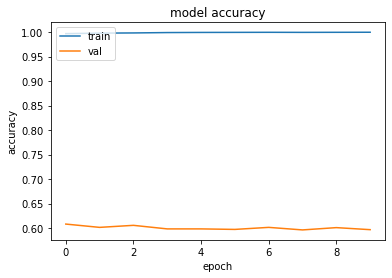

In [236]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [211]:
e = model.layers[0] # output of the embedding
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)
